In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl 
import matplotlib.pyplot as plt
import os
import scipy.stats as st
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams["font.sans-serif"] = "Arial"


# Calculated Accuracy score for every datasets of each methods

In [2]:
###Input files

path='FigureData/Figure2/'
order = ['gimVI','SpaGE','Tangram','Seurat','SpaOTsc','Liger','NovoSparc']
Tools=['SpaGE','gimVI','Tangram','Seurat','SpaOTsc','LIGER','novoSpaRc']
image_based_dataset = ["Dataset1","Dataset2","Dataset3","Dataset4",'Dataset5','Dataset6',"Dataset7","Dataset8"]
seq_based_dataset = ["Dataset9","Dataset10",'Dataset11','Dataset12','Dataset13','Dataset14']
palette = ['#F9EC31','#D6DE23','#F5A8C7','#988DC3','#BBA8D1','#A2CBCF','#7BD1F1']

os.popen('mkdir ' + path + 'Accuracy_Rank')
path_output = path + '/Accuracy_Rank/'


In [3]:
###This script is used for rank get the rank score for each method

def get_score(Result):
    Result = Result.fillna(0)
    tools_num = Result.shape[0]
    Tools_score=[]
    methods = list(Result.index)
    score_col = []
    list_up = list(range(1,Result.shape[1]+1))
    list_down  = list(range(Result.shape[1],0,-1))
    
    for method in methods:
        if method == 'PCC' or method == 'SSIM':
            Tools_score.append(pd.Series(list_down, index=Result.loc[method,:].sort_values(ascending=False).index))
            
        if method == 'JS' or method == 'RMSE':
            Tools_score.append(pd.Series(list_up, index=Result.loc[method,:].sort_values(ascending=False).index))
        score_col.append(method)
        
    score=pd.concat([m for m in Tools_score],axis=1)
    score.columns = score_col
    score = score/Result.shape[1]
    return score

def make_score(dataset_all, Tools, path_output):
    Tools_data=[x for x in range(len(Tools))]
    for dataset in dataset_all:
        RemoveData = {}
        for i in range(len(Tools)):
            File = path + Tools[i] + '/' + dataset + '/metrics.txt'
            if os.path.isfile(File): 
                Tools_data[i]=pd.read_table(path + Tools[i] + '/' + dataset + '/metrics.txt',sep='\t',index_col=0, header=0)
                Tools_data[i] = Tools_data[i].mean()
                Tools_data[i]['Tool'] = Tools[i]
            else:
                if dataset not in RemoveData:
                    RemoveData[dataset] = []
                RemoveData[dataset].append(Tools[i])
                continue
                
        Result=pd.concat([m for m in Tools_data],axis=1)
        Result.columns = Result.loc[["Tool"],:].values.flatten()
        Result.drop('Tool',axis=0, inplace=True)
        
        for D in RemoveData:
            for T in RemoveData[D]:
                Result = Result.drop(T,axis=1)       
            
        score = get_score(Result)
        score.to_csv(path_output + dataset +"_score.txt",header=1, index=1)

dataset_all = image_based_dataset.copy()
dataset_all.extend(seq_based_dataset)
make_score(dataset_all, Tools, path_output)


In [4]:
###Calculated average accuracy score for image or seq-based datasets

def make_all_score(dataset_all):
    score_all = pd.DataFrame()
    for dataset in dataset_all:
        a = pd.read_csv(path + '/Accuracy_Rank/'+dataset+"_score.txt",header=0,index_col=0)
        score_all=pd.concat([score_all,a],axis=0)
    return score_all


image_based = make_all_score(image_based_dataset)
image_based.to_csv(path + "/Accuracy_Rank/image_based_score.txt",header=1, index=1)

seq_based = make_all_score(seq_based_dataset)
seq_based.to_csv(path + "/Accuracy_Rank/seq_based_score.txt",header=1, index=1)


# Plot the accuracy figures

In [5]:
plot_image = pd.read_csv(path + "/Accuracy_Rank/image_based_score.txt",header=0,index_col=0)
plot_seq = pd.read_csv(path + "/Accuracy_Rank/seq_based_score.txt",header=0,index_col=0)
order = ['gimVI','SpaGE','Tangram','Seurat','SpaOTsc','LIGER','novoSpaRc']
palette = ['#F9EC31','#D6DE23','#F5A8C7','#988DC3','#BBA8D1','#A2CBCF','#7BD1F1']

def plot_all(df, name, order, palette):
    df_all = pd.DataFrame(df.sum(axis=1).values,index = df.index.values,columns=['merge'])
    df_all = df_all/4
    
    plt.figure(figsize=(4, 3))
    axes =sns.boxplot(x= 'merge',y= df_all.index.values, data=df_all ,palette=palette,order=order)
    axes.set_xlabel(name, fontsize=10)
    axes.set_ylabel('', fontsize=10)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.savefig(path + "/Accuracy_Rank/" + name + '_boxplot.pdf')
    plt.show()
    


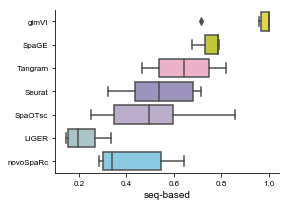

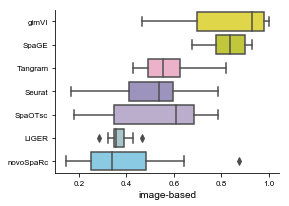

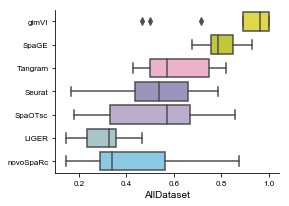

In [6]:
plot_all(plot_seq, 'seq-based', order, palette)
plot_all(plot_image, 'image-based', order, palette)

plot_merge = pd.concat([plot_image,plot_seq],axis=0,join='outer')
plot_all(plot_merge, 'AllDataset', order, palette)


In [7]:
def make_plot_one_dataset(dataset,order,palette):
    for Data in dataset:
        dataset = pd.read_csv(path + '/Accuracy_Rank/'+ Data +"_score.txt",header=0,index_col=0)

        dataset_mer = pd.concat([dataset.iloc[:,0],dataset.iloc[:,1],dataset.iloc[:,2],dataset.iloc[:,3]],axis=0)
        dataset_mer  = pd.DataFrame(dataset_mer,index =dataset_mer.index.values,columns=[Data])
        
    
        axes =sns.violinplot(x= Data,y= dataset_mer.index.values, data=dataset_mer ,order=order,palette=palette, width=0.9)
        axes.set_xlabel(Data, fontsize=10)
        axes.set_ylabel('', fontsize=10)
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        plt.savefig(path + 'Accuracy_Rank/'+ Data +"_violinplot.pdf")
        plt.show()

    

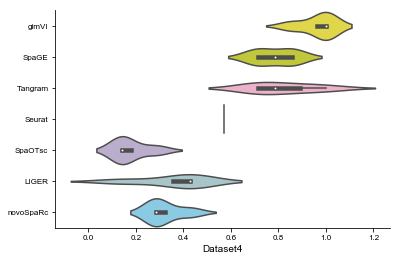

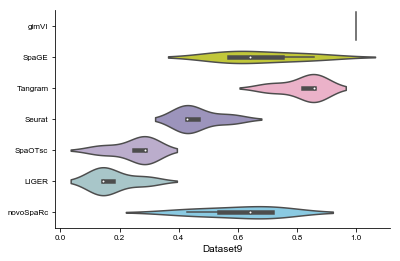

In [8]:
dataset=['Dataset4','Dataset9']
make_plot_one_dataset(dataset,order,palette)
